In [80]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import StandardScaler
import copy
import seaborn as sns
import tensorflow as tf
from sklearn.linear_model import LinearRegression

In [81]:
dataset_cols = ["bike_count", "hour", "temp", "humidity", "wind", "visibility", "dew_pt_temp", "raditation", "rain", "snow", "functional"]
df = pd.read_csv("SeoulBikeData.csv").drop(["Date", "Holiday", "Seasons"], axis=1)

In [82]:
df.columns = dataset_cols
df["functional"] = (df["functional"] == "Yes").astype(int)
df = df[df["hour"] == 12]
df = df.drop(["hour"], axis=1)
df = df.drop(["wind", "functional", "visibility"], axis=1)

In [83]:
df.head()

,bike_count,temp,humidity,dew_pt_temp,raditation,rain,snow
12,449,1.7,23,-17.2,1.11,0.0,0.0
36,479,4.3,41,-7.8,1.09,0.0,0.0
60,333,5.8,85,3.4,0.43,0.0,0.0
84,393,-0.3,38,-12.9,1.11,0.0,0.0
108,321,-2.3,25,-19.7,0.00,0.0,0.0


In [ ]:
for label in df.columns[1:]:
    plt.scatter(df[label], df["bike_count"])
    plt.ylabel("Bike Count at Noon")
    plt.xlabel(label)
    plt.show()

# Train/Valid/Test

In [85]:
train, val, test = np.split(df.sample(frac=1), [int(0.6*len(df)), int(0.8*len(df))])

/Users/adi/Library/Python/3.11/lib/python/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [86]:
def get_xy(dataframe, y_label, x_label=None):
    dataframe = copy.deepcopy(dataframe)
    if x_label is None:
        X = dataframe[[c for c in dataframe.columns if c != y_label]].values
    else:
        if len(x_label) == 1:
            X = dataframe[x_label[0]].values.reshape(-1, 1)
        else:
            X = dataframe[x_label].values
        
    y = dataframe[y_label].values.reshape(-1, 1)
    data = np.hstack((X, y))

    return data, X, y

In [87]:
_, X_train_temp, y_train_temp = get_xy(df, "bike_count", x_label=["temp"])
_, X_val_temp, y_val_temp = get_xy(df, "bike_count", x_label=["temp"])
_, X_test_temp, y_test_temp = get_xy(df, "bike_count", x_label=["temp"])

In [88]:
temp_reg = LinearRegression()
temp_reg.fit(X_train_temp, y_train_temp)

LinearRegression()

In [89]:
print(temp_reg.coef_, temp_reg.intercept_)

[[20.84124918]] [377.18970415]


In [90]:
temp_reg.score(X_test_temp, y_test_temp)

0.330867186499053

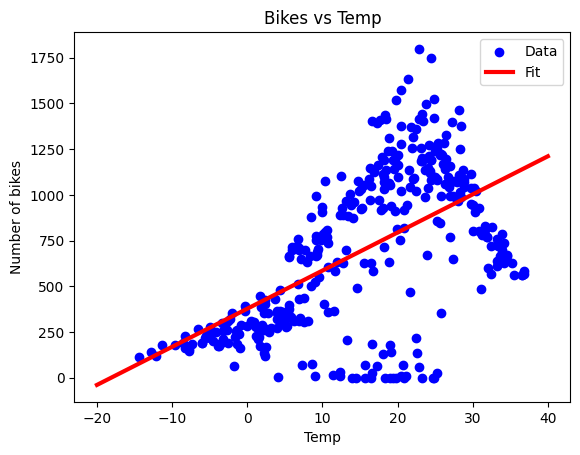

In [30]:
plt.scatter(X_train_temp, y_train_temp, label="Data", color="blue")
x = tf.linspace(-20, 40, 100)
plt.plot(x, temp_reg.predict(np.array(x).reshape(-1, 1)), label="Fit", color="red", linewidth=3)
plt.legend()
plt.title("Bikes vs Temp")
plt.ylabel("Number of bikes")
plt.xlabel("Temp")
plt.show()

# Multiple Linear Regression

In [91]:
train, val, test = np.split(df.sample(frac=1), [int(0.6*len(df)), int(0.8*len(df))])
_, X_train_all, y_train_all = get_xy(train, "bike_count", x_label=df.columns[1:])
_, X_val_all, y_val_all = get_xy(val, "bike_count", x_label=df.columns[1:])
_, X_test_all, y_test_all = get_xy(test, "bike_count", x_label=df.columns[1:])

/Users/adi/Library/Python/3.11/lib/python/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [92]:
all_reg = LinearRegression()
all_reg.fit(X_train_all, y_train_all)

LinearRegression()

In [93]:
all_reg.score(X_test_all, y_test_all)

0.6094845567025478

# Regression with Neural net

In [95]:
temp_normalizer = tf.keras.layers.Normalization(input_shape=(1,), axis=None)
temp_normalizer.adapt(X_train_temp.reshape(-1))

/Users/adi/Library/Python/3.11/lib/python/site-packages/keras/src/layers/preprocessing/normalization.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [96]:
temp_nn_model = tf.keras.Sequential([
    temp_normalizer,
    tf.keras.layers.Dense(1)
])

In [99]:
temp_nn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.1), loss='mean_squared_error')

In [100]:
history = temp_nn_model.fit(
    X_train_temp.reshape(-1), y_train_temp,
    verbose = 0,
    epochs = 1000,
    validation_data=(X_val_temp, y_val_temp)
)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


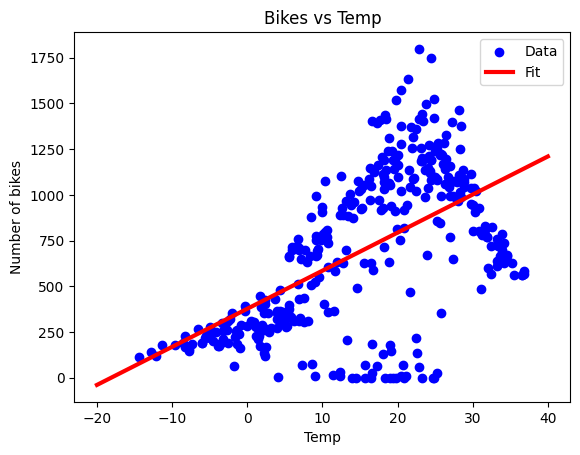

In [101]:
plt.scatter(X_train_temp, y_train_temp, label="Data", color="blue")
x = tf.linspace(-20, 40, 100)
plt.plot(x, temp_nn_model.predict(np.array(x).reshape(-1, 1)), label="Fit", color="red", linewidth=3)
plt.legend()
plt.title("Bikes vs Temp")
plt.ylabel("Number of bikes")
plt.xlabel("Temp")
plt.show()

# Neural Net

In [110]:
temp_normalizer = tf.keras.layers.Normalization(input_shape=(1,), axis=None)
temp_normalizer.adapt(X_train_temp.reshape(-1))

nn_model = tf.keras.Sequential([
    temp_normalizer,
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1)
])
nn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mean_squared_error')

In [111]:
history = nn_model.fit(
    X_train_temp, y_train_temp,
    validation_data = (X_val_temp, y_val_temp),
    verbose=0, epochs=100
)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 587us/step


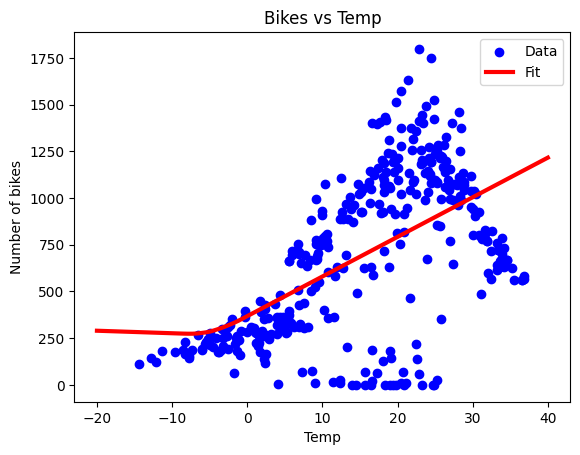

In [114]:
plt.scatter(X_train_temp, y_train_temp, label="Data", color="blue")
x = tf.linspace(-20, 40, 100)
plt.plot(x, nn_model.predict(np.array(x).reshape(-1, 1)), label="Fit", color="red", linewidth=3)
plt.legend()
plt.title("Bikes vs Temp")
plt.ylabel("Number of bikes")
plt.xlabel("Temp")
plt.show()

In [117]:
all_normalizer = tf.keras.layers.Normalization(input_shape=(6,1), axis=None)
all_normalizer.adapt(X_train_all.reshape(-1))

nn_model = tf.keras.Sequential([
    all_normalizer,
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1)
])
nn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mean_squared_error')

In [ ]:
history = nn_model.fit(
    X_train_all, y_train_all,
    validation_data = (X_val_all, y_val_all),
    verbose=0, epochs=100
)